# Vector Representations of Words

https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html

https://github.com/tensorflow/tensorflow/blob/r0.11/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

http://mattmahoney.net/dc/textdata

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

**Step 1: Download the data.**

In [2]:
import os
import zipfile

HOME_DIR = 'word2vec'
DATA_DIR = os.path.join(HOME_DIR, 'data')

TRAINING_NAME = 'text8.zip'

TRAINING_FILE = os.path.join(DATA_DIR, TRAINING_NAME)

from tensorflow.contrib.learn.python.learn.datasets.base import maybe_download
maybe_download(TRAINING_NAME, DATA_DIR, 'http://mattmahoney.net/dc/text8.zip')

# Read the data into a list of strings.
with zipfile.ZipFile(TRAINING_FILE) as f:
    first_file = f.namelist()[0]
    text = f.read(first_file)
    words = tf.compat.as_str(text).split()

print('Data size:', len(words))

Data size: 17005207


**Step 2: Build the dictionary and replace rare words with UNK token.**

In [3]:
vocabulary_size = 50000

In [4]:
import collections

count = [['UNK', -1]]
count.extend(collections.Counter(words).most_common(vocabulary_size - 1))

dictionary = dict()
for word, _ in count:
    dictionary[word] = len(dictionary)

data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0  # dictionary['UNK']
        unk_count += 1
    data.append(index)

count[0][1] = unk_count
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


**Step 3: Function to generate a training batch for the skip-gram model.**

In [5]:
import random
import numpy as np

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3084 originated -> 5239 anarchism
3084 originated -> 12 as
12 as -> 6 a
12 as -> 3084 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of


**Step 4: Build and train a skip-gram model.**

In [6]:
import math

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal(
            [vocabulary_size, embedding_size],
            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            nce_weights,
            nce_biases,
            embed,
            train_labels,
            num_sampled,
            vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.initialize_all_variables()

**Step 5: Begin training.**

In [7]:
from six.moves import xrange

num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  269.600158691
Nearest to new: knut, either, deconvolution, tahitian, superheroic, dualities, mande, amaranthus,
Nearest to nine: teh, jensen, niue, inscriptions, pavel, transceiver, acosta, tamara,
Nearest to seven: darth, sought, xxx, reunified, teeth, caesars, nme, micrometre,
Nearest to some: templar, bodied, await, letterbox, extremism, tut, unchecked, adams,
Nearest to which: taped, overstated, transports, fabricated, fertilization, interrupt, adjustments, hays,
Nearest to as: throws, intensive, malign, faroese, decayed, trick, slicing, tasks,
Nearest to when: thoreau, absolute, ironworks, satirizes, herg, mali, wilton, coyne,
Nearest to more: rainforest, parliamentarism, hiring, shawnee, reichsf, whichever, guaranteed, investment,
Nearest to in: lingers, spikes, montrealers, alonzo, inhibitors, blotter, asser, vices,
Nearest to all: repay, homelands, instrumentalist, merchant, hallucination, adhered, philanthropist, nva,
Nearest to may: conf

**Step 6: Visualize the embeddings.**

/home/cavani/Source/tensorflow-jupyter/deps/tensorflow-0.11/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


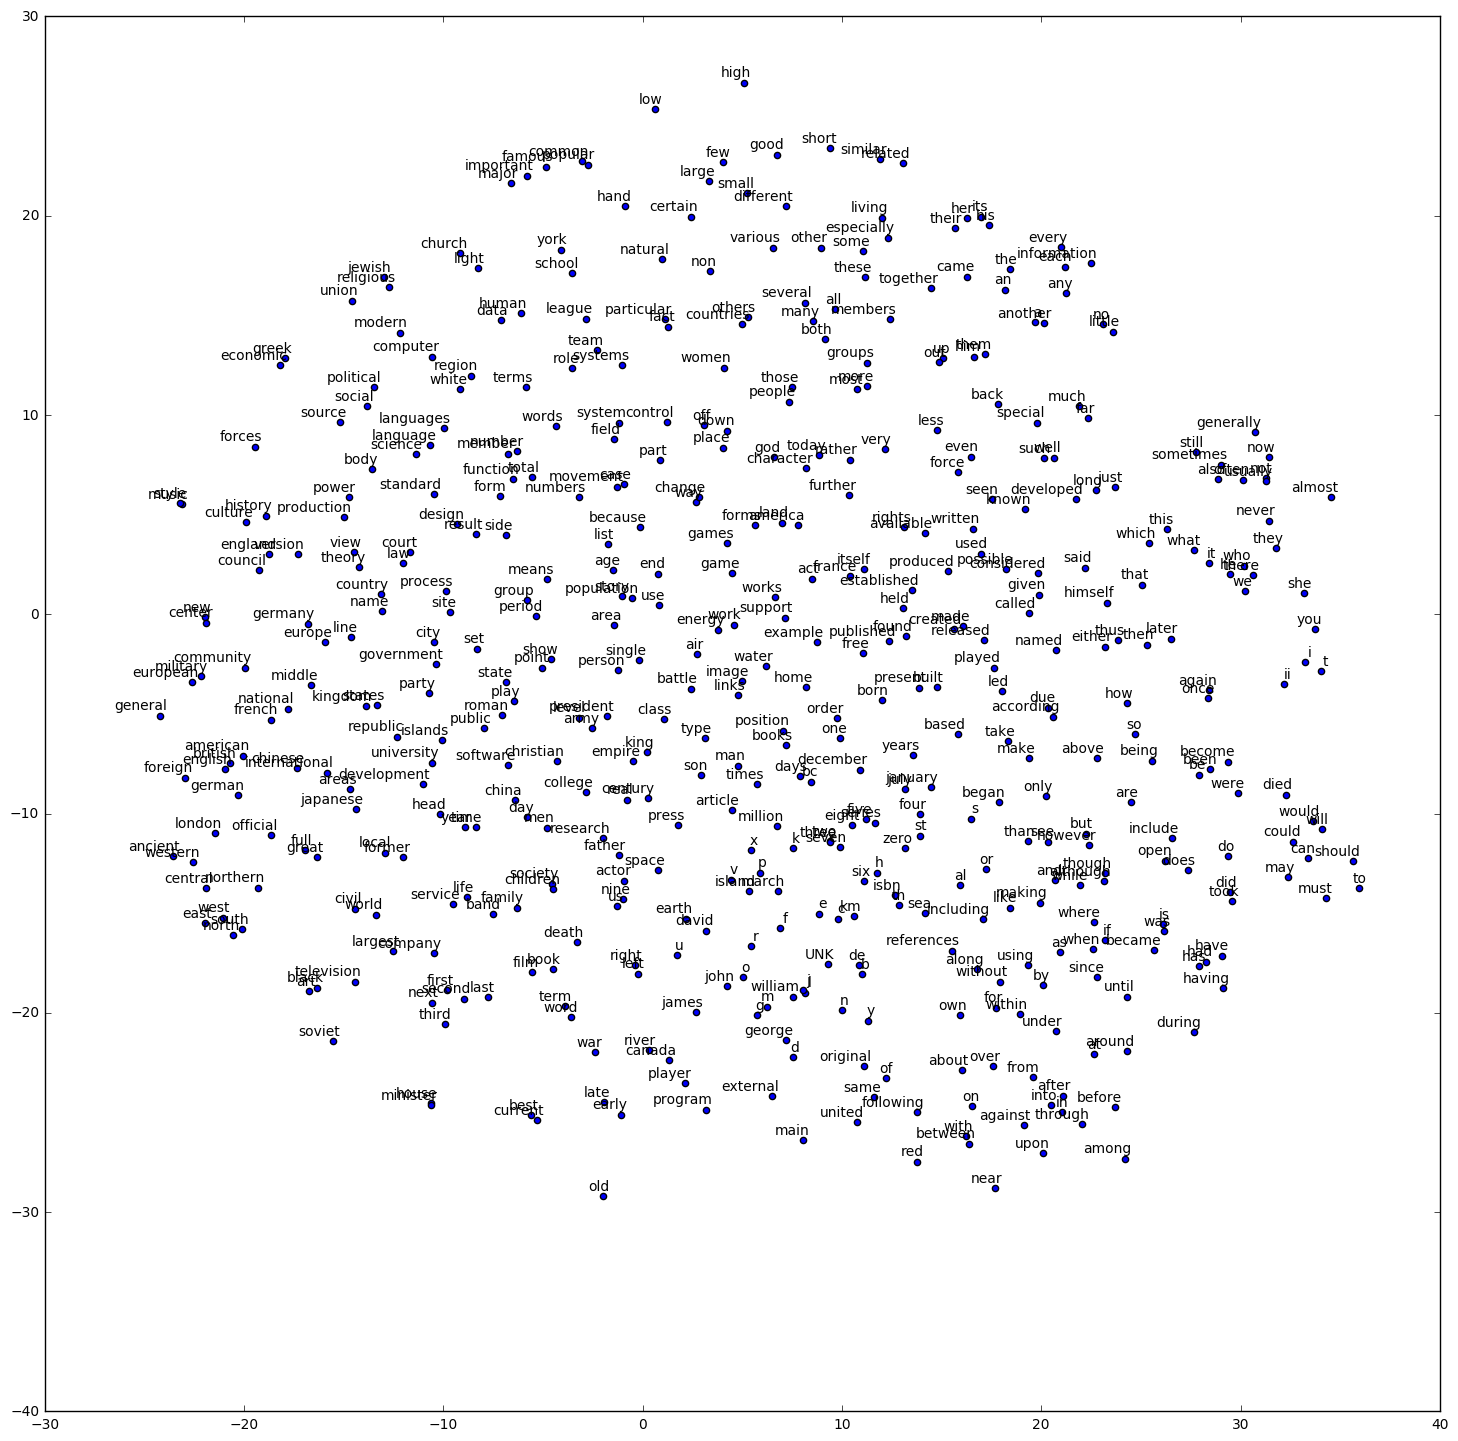

In [8]:
%matplotlib inline

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]

plt.figure(figsize=(18, 18))  #in inches
for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

plt.show()